In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt

# Download a dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32') / 255, y_train)).shuffle(1024).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test[y_test==2].astype('float32') / 255, y_test[y_test==2])).batch(32)

In [2]:
class VFLPassiveModel(Model):
    def __init__(self):
        super(VFLPassiveModel, self).__init__()
        self.flatten = Flatten()
        self.d1 = Dense(10, name="dense1")

    def call(self, x):
        x = self.flatten(x)
        return self.d1(x)

In [3]:
class VFLActiveModel(Model):
    def __init__(self):
        super(VFLActiveModel, self).__init__()
        self.added = tf.keras.layers.Add()

    def call(self, x):
        x = self.added(x)
        return tf.keras.layers.Softmax()(x)

In [7]:
passive_model = VFLPassiveModel()
active_model = VFLActiveModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
    # For each batch of images and labels
    for images, labels in train_ds:
        with tf.GradientTape() as passive_tape:
            # passive_model sends passive_output to active_model
            passive_output = passive_model(images)
            with tf.GradientTape() as active_tape:
                active_tape.watch(passive_output)
                active_output = active_model([passive_output, passive_output])
                loss = loss_object(labels, active_output)
            # active_model sends passive_output_gradients back to passive_model
            passive_output_gradients = active_tape.gradient(loss, passive_output)
            #print(passive_output_gradients)
            passive_output_lost = tf.multiply(passive_output, passive_output_gradients.numpy())
        passive_weight_gradients = passive_tape.gradient(passive_output_lost, passive_model.trainable_variables)
        optimizer.apply_gradients(zip(passive_weight_gradients, passive_model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, active_output)

    for test_images, test_labels in test_ds:
        passive_output = passive_model(test_images)
        active_output = active_model([passive_output, passive_output])
        t_loss = loss_object(test_labels, active_output)

        test_loss(t_loss)
        test_accuracy(test_labels, active_output)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.405218243598938, Accuracy: 88.75, Test Loss: 0.4513963758945465, Test Accuracy: 87.30619812011719
Epoch 2, Loss: 0.2906039357185364, Accuracy: 91.85832977294922, Test Loss: 0.4250626266002655, Test Accuracy: 87.8875961303711
Epoch 3, Loss: 0.27544891834259033, Accuracy: 92.40166473388672, Test Loss: 0.459330677986145, Test Accuracy: 87.4030990600586
Epoch 4, Loss: 0.26715561747550964, Accuracy: 92.53500366210938, Test Loss: 0.4625568687915802, Test Accuracy: 87.1124038696289
Epoch 5, Loss: 0.2622341513633728, Accuracy: 92.7066650390625, Test Loss: 0.5050548315048218, Test Accuracy: 86.33721160888672


In [4]:
import numpy as np

def get_possioned_gradients(passive_output_gradients, passive_output, N, class1, class2, alpha = 1.0):
    passive_output_gradients -= passive_output
    #print(passive_output_gradients)
    attack_mat = np.eye(N, dtype='float32')
    attack_mat[:, class2] += attack_mat[:, class1]*alpha
    attack_mat[:, class1] -= attack_mat[:, class1]*alpha
    #print(attack_mat)
    passive_output_gradients = tf.matmul(passive_output_gradients, attack_mat)
    passive_output_gradients += passive_output
    return passive_output_gradients

In [5]:
passive_model = VFLPassiveModel()
active_model = VFLActiveModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
    # For each batch of images and labels
    for images, labels in train_ds:
        with tf.GradientTape() as passive_tape:
            # passive_model sends passive_output to active_model
            passive_output = passive_model(images)
            with tf.GradientTape() as active_tape:
                active_tape.watch(passive_output)
                active_output = active_model([passive_output, passive_output])
                loss = loss_object(labels, active_output)
            # active_model sends passive_output_gradients back to passive_model
            passive_output_gradients = active_tape.gradient(loss, passive_output)
            passive_output_gradients = \
            get_possioned_gradients(passive_output_gradients, passive_output, 10, 2, 4)
            passive_output_loss = tf.multiply(passive_output, passive_output_gradients.numpy())
        passive_weight_gradients = passive_tape.gradient(passive_output_loss, passive_model.trainable_variables)
        optimizer.apply_gradients(zip(passive_weight_gradients, passive_model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, active_output)

    for test_images, test_labels in test_ds:
        passive_output = passive_model(test_images)
        active_output = active_model([passive_output, passive_output])
        t_loss = loss_object(test_labels, active_output)

        test_loss(t_loss)
        test_accuracy(test_labels, active_output)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.5872719287872314, Accuracy: 81.26000213623047, Test Loss: 1.1180531978607178, Test Accuracy: 45.54263687133789
Epoch 2, Loss: 0.47115832567214966, Accuracy: 83.81166076660156, Test Loss: 1.2937822341918945, Test Accuracy: 33.81782913208008
Epoch 3, Loss: 0.47255071997642517, Accuracy: 83.44166564941406, Test Loss: 1.4451520442962646, Test Accuracy: 27.03488540649414
Epoch 4, Loss: 0.4741647243499756, Accuracy: 83.53666687011719, Test Loss: 1.561234474182129, Test Accuracy: 23.643409729003906
Epoch 5, Loss: 0.475004643201828, Accuracy: 83.59000396728516, Test Loss: 1.557436466217041, Test Accuracy: 25.387596130371094


[ 14.362151    9.        224.04999    47.196995  522.3977      0.637849
  22.          6.9999685 178.35532     7.0000315]


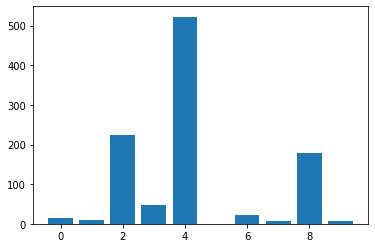

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x_val = x_test[y_test==2]
y_val = y_test[y_test==2]

passive_output = passive_model(x_val)
active_output = active_model([passive_output, passive_output])

output_distribution = np.sum(active_output, axis=0)
print(output_distribution)

n = 10
X = np.arange(n)
plt.bar(X, output_distribution)

plt.show()

In [36]:
N = 10
class1 = 2
class2 = 4
alpha = 1.0

attack_mat = np.eye(N, dtype='float32')
attack_mat[:, class2] += attack_mat[:, class1]*alpha
attack_mat[:, class1] -= attack_mat[:, class1]*alpha

a = np.random.rand(3, N)
print(attack_mat)
b = np.matmul(a, attack_mat)
print(a)
b

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.5301766  0.36834355 0.0751616  0.34628156 0.67369025 0.71920954
  0.39001503 0.05330744 0.60812417 0.57757241]
 [0.11696672 0.91286319 0.76614699 0.18240779 0.34124305 0.64034105
  0.14179049 0.5599264  0.92628808 0.04293072]
 [0.8208049  0.58776502 0.82512238 0.75042469 0.143793   0.9864077
  0.28055798 0.66674831 0.15096047 0.8785071 ]]


array([[0.5301766 , 0.36834355, 0.        , 0.34628156, 0.74885185,
        0.71920954, 0.39001503, 0.05330744, 0.60812417, 0.57757241],
       [0.11696672, 0.91286319, 0.        , 0.18240779, 1.10739004,
        0.64034105, 0.14179049, 0.5599264 , 0.92628808, 0.04293072],
       [0.8208049 , 0.58776502, 0.        , 0.75042469, 0.96891539,
        0.9864077 , 0.28055798, 0.66674831, 0.15096047, 0.8785071 ]])